In [1]:
import random 
import numpy as np
import mesa
import matplotlib.pyplot as plt

### GetArnhemData

In [2]:
import pandas as pd

# Use the provided CSVs (semicolon-separated). Adjust paths if needed.
pop_path = 'data/Bevolking - Centrum.csv'         # population by wijk
map_path = 'data/dataset kaart gemeente.csv'     # wijk metadata

pop_df = pd.read_csv(pop_path, sep=';', index_col=False)
map_df = pd.read_csv(map_path, sep=';', encoding='utf-8', low_memory=False)

arnhem_total = float(pop_df.loc[pop_df["buurt of wijk / dimensie"].str.lower()=="arnhem", "Waarde"].iloc[0])

wijken = pop_df[pop_df["buurt of wijk / dimensie"].str.lower()!="arnhem"][["buurt of wijk / dimensie","Waarde"]].copy()
wijken["Waarde"] = pd.to_numeric(wijken["Waarde"], errors="coerce")
wijken["share"] = wijken["Waarde"] / arnhem_total

wijk_share_dict = dict(zip(wijken["buurt of wijk / dimensie"], wijken["share"]))
del wijk_share_dict['Onbekend binnen Arnhem']
wijk_share_dict


{'Centrum': 0.042078842462719625,
 'Spijkerkwartier': 0.04039568876421084,
 'Arnhemse Broek': 0.04479551159013731,
 'Presikhaaf-West': 0.05253211280082681,
 'Presikhaaf-Oost': 0.04553373689650081,
 'St.Marten/Sonsbeek': 0.03375166100693932,
 'Klarendal': 0.042698951720064965,
 'Velperweg e.o.': 0.05507160785471726,
 'Alteveer/Cranevelt': 0.0206998375904326,
 'Geitenkamp': 0.022471578325705004,
 'Monnikenhuizen': 0.026192233869777055,
 'Burgemeesterswijk/Hoogkamp': 0.04630149121511885,
 'Schaarsbergen e.o.': 0.01411486785767016,
 'Heijenoord/Lombok': 0.022648752399232246,
 'Klingelbeek e.o.': 0.008445297504798464,
 'Malburgen-West': 0.028465967813376642,
 'Malburgen-Oost (Noord)': 0.03779713568581131,
 'Malburgen-Oost (Zuid)': 0.05468773069540824,
 'Vredenburg/Kronenburg': 0.05176435848220877,
 'Elden': 0.01762882031596043,
 'Elderveld': 0.051498597371917906,
 'De Laar': 0.07148973866824154,
 'Rijkerswoerd': 0.0724937250848959,
 'Schuytgraaf': 0.09641222501107338}

In [3]:
import random
import numpy as np
import mesa

def min_max_01(x: float) -> float:
    return max(0.0, min(1.0, x))

class Household(mesa.Agent):
    """A household agent representing family environment."""
    def __init__(self, model, family_support_level: float):
        super().__init__(model)
        self.family_support_level = family_support_level # 0..1
        self.issues = random.uniform(0, 1) # 0..1


class SchoolAgent(mesa.Agent):
    """A school agent representing educational environment."""
    def __init__(self, model, quality_level: float):
        super().__init__(model)
        self.quality_level = quality_level # 0..1
        self.resources = random.uniform(0, 1) # 0..1


class YouthAgent(mesa.Agent):
    """An agent representing a youth with risk propensity and peer influence."""
    def __init__(self, model, age, neighbourhood_id, household, friend_group, school_status='enrolled'):
        super().__init__(model)

        self.age = age
        self.neighbourhood_id = neighbourhood_id
        self.household = household
        self.friend_group = friend_group

        # Individual traits / states
        # self.crime_involvement = random.uniform(0, 1)  # latent inclination (0..1)
        self.crime_involvement = float(np.random.beta(0.067 * 3.0, (1 - 0.067) * 3.0))

        self.school_status = school_status
        self.criminalrecord = 0

        self.edu_performance = random.uniform(0, 1) # 0..1
        self.edu_motivation = random.uniform(0, 1) # 0..1

        self.family_support = self.household.family_support_level # 0..1
        self.issues_at_home = self.household.issues # 0..1

        self.job_chance = random.uniform(0, 1) # 0..1
        self.criminal_capital = random.uniform(0, 1) # 0..1
        self.job_status = random.choice(['unemployed', 'employed'])

        # Inertia: prevents instant dropout
        self.dropout_risk_streak = 0

        # For peer "recent crime" signal (still used for crime, not for dropout)
        self.last_offended = 0

    def peer_stats(self):
        friends = [a for a in self.friend_group if isinstance(a, YouthAgent)]
        if not friends:
            return 0.0, 0.0
        peer_recent_crime = float(np.mean([f.last_offended for f in friends]))
        peer_dropout_share = float(np.mean([1.0 if f.school_status == 'dropped_out' else 0.0 for f in friends]))
        return peer_recent_crime, peer_dropout_share

    def step(self):
        p = self.model.params
        peer_recent_crime, peer_dropout_share = self.peer_stats()

        # -------------------------
        # 1) Crime (optional; not part of pushed-out dropout)
        # -------------------------
        crime_risk = float(np.mean([
            self.crime_involvement,
            peer_recent_crime,
            self.criminal_capital,
            self.issues_at_home,
            1.0 - self.family_support,
            1.0 if self.school_status == 'dropped_out' else 0.0
        ]))
        p_offend = min_max_01(p["base_offend_halfyear"] * (0.5 + crime_risk))

        offended = 1 if random.random() < p_offend else 0
        self.last_offended = offended

        if offended:
            self.criminalrecord += 1
            self.job_chance = min_max_01(self.job_chance - p["job_penalty_per_offense"])
            self.crime_involvement = min_max_01(self.crime_involvement + p["crime_involvement_drift"])
            self.criminal_capital = min_max_01(self.criminal_capital + p["criminal_capital_gain"])

        # -------------------------
        # 2) Education updates
        # -------------------------
        if self.school_status in ['enrolled', 'at_risk']:
            self.edu_performance = min_max_01(
                self.edu_performance
                + p["perf_gain"] * self.edu_motivation
                + p["perf_gain"] * self.family_support
                - p["perf_loss"] * self.issues_at_home
                - p["perf_loss"] * offended
            )

            self.edu_motivation = min_max_01(
                self.edu_motivation
                + p["mot_gain"] * self.job_chance
                + p["mot_gain"] * self.family_support
                - p["mot_loss"] * self.issues_at_home
                - p["mot_loss"] * offended
            )

        # -------------------------
        # 3) Dropout = PUSHED OUT only (with inertia)
        # -------------------------
        if self.school_status in ['enrolled', 'at_risk']:

            # pushed-out risk only:
            # low performance + low motivation + home issues + low support + peers dropping out
            pushed_risk = float(np.mean([
                1.0 - self.edu_performance,
                1.0 - self.edu_motivation,
                self.issues_at_home,
                1.0 - self.family_support,
                peer_dropout_share
            ]))

            # small half-year hazard (key to not exploding)
            p_dropout = min_max_01(p["base_dropout_halfyear"] * (0.5 + pushed_risk))

            # optional: only within school-age window
            if not (p["dropout_age_min"] <= self.age <= p["dropout_age_max"]):
                p_dropout = 0.0

            # inertia: need multiple risky steps
            if random.random() < p_dropout:
                self.dropout_risk_streak += 1
            else:
                self.dropout_risk_streak = max(0, self.dropout_risk_streak - 1)

            if self.dropout_risk_streak >= p["streak_to_at_risk"]:
                self.school_status = 'at_risk'
            if self.dropout_risk_streak >= p["streak_to_dropout"]:
                self.school_status = 'dropped_out'

        # -------------------------
        # 4) Completion & jobs
        # -------------------------
        if self.age > 17 and self.school_status == 'enrolled' and self.edu_performance >= p["completion_perf_threshold"]:
            self.school_status = 'completed'
            self.job_chance = min_max_01(self.job_chance + p["job_bonus_on_completion"])

        if self.school_status == 'completed' and self.job_status == 'unemployed':
            if random.random() < self.job_chance:
                self.job_status = 'employed'

        # -------------------------
        # 5) Age / exit
        # -------------------------
        self.age += 0.5
        if self.age >= 24:
            self.remove()
            return


class YouthCrimeModel(mesa.Model):
    def __init__(self, N_initial, N_yearly, neighbourhood_proportions=None):
        super().__init__()
        self.num_agents = N_initial
        self.N_yearly = N_yearly
        # Accept neighbourhood proportions (dict or None)
        self.neighbourhood_proportions = neighbourhood_proportions

        if self.neighbourhood_proportions:
            self.neigh_names = list(self.neighbourhood_proportions.keys())
            probs = np.array([self.neighbourhood_proportions[n] for n in self.neigh_names], dtype=float)
            self.neigh_probs = probs / probs.sum()  # normalize just in case
        else:
            self.neigh_names = None
            self.neigh_probs = None

        # Minimal, interpretable parameters
        self.params = {
            # Half-year hazards (step=0.5 years)
            "base_dropout_halfyear": 0.02,   # main knob for pushed-out dropout
            "base_offend_halfyear": 0.06,

            # Education dynamics
            "perf_gain": 0.03,
            "perf_loss": 0.03,
            "mot_gain": 0.02,
            "mot_loss": 0.02,

            # Crime/job links (optional)
            "job_penalty_per_offense": 0.01,
            "crime_involvement_drift": 0.01,
            "criminal_capital_gain": 0.02,

            # Dropout inertia
            "streak_to_at_risk": 2,
            "streak_to_dropout": 4,

            # Age window where dropout risk is allowed
            "dropout_age_min": 12,
            "dropout_age_max": 20,

            # Completion
            "completion_perf_threshold": 0.60,
            "job_bonus_on_completion": 0.20,
        }

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Average Crime Involvement": lambda m: np.mean([a.crime_involvement for a in m.agents if isinstance(a, YouthAgent)]),
                "Average Edu Motivation": lambda m: np.mean([a.edu_motivation for a in m.agents if isinstance(a, YouthAgent)]),
                "Average Edu Performance": lambda m: np.mean([a.edu_performance for a in m.agents if isinstance(a, YouthAgent)]),
                "Average Job Chance": lambda m: np.mean([a.job_chance for a in m.agents if isinstance(a, YouthAgent)]),
                "Drop out Rate": lambda m: np.mean([1 if a.school_status == 'dropped_out' else 0 for a in m.agents if isinstance(a, YouthAgent)]),
                "Completed Rate": lambda m: np.mean([1 if a.school_status == 'completed' else 0 for a in m.agents if isinstance(a, YouthAgent)]),
            },
            agent_reporters={
                "Age": lambda a: a.age if isinstance(a, YouthAgent) else None,
                "Crime Involvement": "crime_involvement",
                "Criminal record": "criminalrecord",
                "Edu Motivation": "edu_motivation",
                "Edu Performance": "edu_performance",
                "Job Chance": "job_chance",
                "School status": "school_status",
                "Dropout streak": "dropout_risk_streak",
            }
        )

        # Create households
        self.households = [Household(self, random.uniform(0, 1)) for _ in range(max(1, N_initial // 4))]



        # Create initial youth distributed by neighbourhood_proportions if provided
        for _ in range(self.num_agents):
            YouthAgent(
                self,
                age=random.randint(12, 24),
                neighbourhood_id=self.sample_neighbourhood(),
                household=random.choice(self.households),
                friend_group=[]
            )

        self.assign_friend_groups(k=5)

        # Initial dropout share (~4.6%)
        youths = [a for a in self.agents if isinstance(a, YouthAgent)]
        initial_k = int(0.046 * len(youths))
        if initial_k > 0:
            for agent in random.sample(youths, k=initial_k):
                agent.school_status = 'dropped_out'

    def assign_friend_groups(self, k=5):
        youths = [a for a in self.agents if isinstance(a, YouthAgent)]
        for agent in youths:
            pool = [a for a in youths if a is not agent]
            agent.friend_group = random.sample(pool, k=min(k, len(pool)))

    def assign_friend_groups_for(self, agents, k=5):
        youths = [a for a in self.agents if isinstance(a, YouthAgent)]
        for a in agents:
            pool = [x for x in youths if x is not a]
            a.friend_group = random.sample(pool, k=min(k, len(pool)))

    # Helper: sample neighbourhood id according to proportions
    def sample_neighbourhood(self):
        if self.neigh_names is not None:
            return str(np.random.choice(self.neigh_names, p=self.neigh_probs))
        else:
            return random.randint(0, 5)

    def step(self):
        self.datacollector.collect(self)
        self.agents.do('step')

        # Add new youth once per year (2 steps because step = 0.5 years)
        if (self.steps % 2) == 0 and self.N_yearly > 0:
            # create N_yearly new agents and assign friend groups to them
            new_agents = []
            for _ in range(self.N_yearly):
                a = YouthAgent(
                    self,
                    age=10,
                    neighbourhood_id=self.sample_neighbourhood(),
                    household=random.choice(self.households),
                    friend_group=[],
                    school_status='enrolled'
                )
                new_agents.append(a)
            self.assign_friend_groups_for(new_agents, k=5)


In [4]:
# Run the model

# Use computed neighbourhood_proportions when instantiating the model:
model = YouthCrimeModel(2800, 100, neighbourhood_proportions=wijk_share_dict)
for i in range(50):
    model.step()

model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

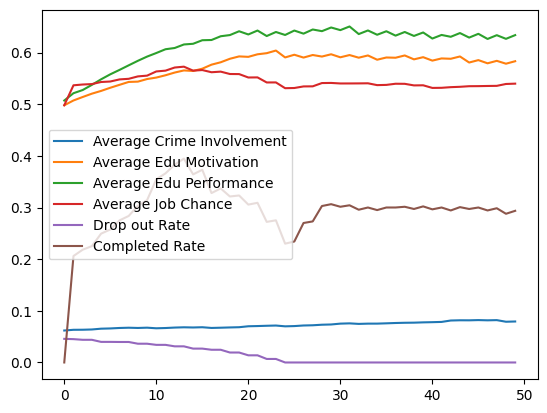

In [5]:
model_data.plot()
plt.show()